Variable Definitions
<p>
    <ul>
        <li>Surburb: Surburb</li>
        <li>Address: Address</li>
        <li>Rooms: Number of rooms</li>
        <li>Price: Price in Australian dollars</li>
        <li>Method: Method of Sale. How the property was sold</li>
        <li>Type: Building Type</li>
        <li>SellerG: Real Estate Agent</li>
        <li>Date: Date Property was sold</li>
        <li>Distance: Distance from CBD in Kilometres</li>
        <li>Regionname: General Region</li>
        <li>Propertycount: Number of properties that exist in the suburb.</li>
        <li>Bedrooms2: Number of Bedrooms</li>
        <li>Bathroom: Number of Bathrooms</li>
        <li>Car: Number of carspots</li>
        <li>Landsize: Land Size in Metres</li>
        <li>BuildingArea: Building Size in Metres</li>
        <li>YearBuilt: Year the house was built</li>
        <li>CouncilArea: Governing council for the area</li>
        <li>Latitude: Location Latitude </li>
        <li>Longitude: Location Longitude</li>
    </ul>    

<p><b>Objective:</b> To predict the price a property will be sold</p>
<p><b>Evaluation</b>: Root Mean squared Log error</p>

In [1]:
path = r"C:\Machine_learning_datafiles\datasheets\Melbourne housing prices"

In [2]:
import os, gc, warnings
# suppressing error messages
warnings.filterwarnings('ignore')

# changing path
os.chdir(path)

<b>Importing Files</b>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats

In [4]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
import lightgbm as lgb

In [5]:
sns.set()
pd.set_option('display.max_columns', 50)
%matplotlib inline

In [6]:
data = pd.read_csv('Melbourne_housing_FULL.csv')

In [7]:
data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,2.0,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,3.0,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


<b>EDA</b>

In [8]:
data.shape

(34857, 21)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float64
 18  Longti

The dependent variable contains some missing values. We will use them as our test set

In [10]:
data = data.rename(columns={'Longtitude':'Longitude', 'Lattitude':'Latitude', 
                            'Date':'DateSold'})

In [11]:
data.DateSold = pd.to_datetime(data.DateSold)

In [12]:
data.dropna(subset=['Price']).shape

(27247, 21)

In [13]:
train = data[data.Price.notnull()]
test = data[data.Price.isnull()].drop(columns='Price')

In [14]:
train.shape, test.shape

((27247, 21), (7610, 20))

In [15]:
def missing_columns(df):
    missing = df.isna().sum().sort_values(ascending=True)
    missing = missing[missing > 0]
    
    ax = missing.plot.barh()
    for i in ax.patches:
        val = round(i.get_width()/len(df)*100,0).astype(int)
        plt.text(i.get_width()+100, i.get_y()+0.05, 
                 str(val)+'%')

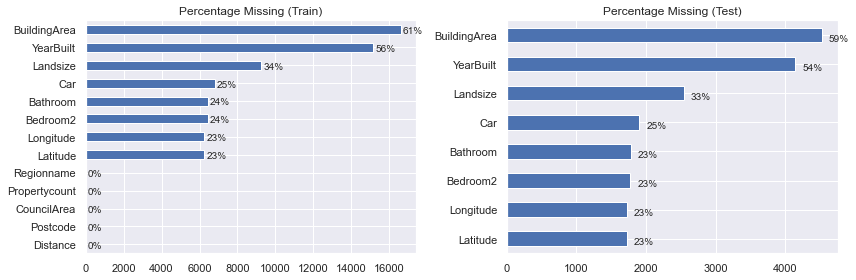

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(121)
missing_columns(train)
plt.title('Percentage Missing (Train)')

plt.subplot(122)
missing_columns(test)
plt.title('Percentage Missing (Test)')
plt.tight_layout();

<hr>

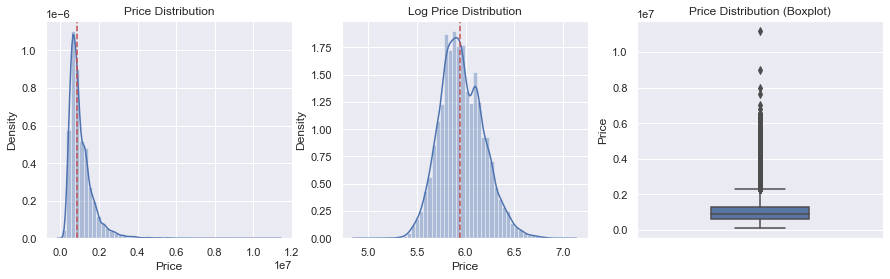

In [17]:
_, ax = plt.subplots(1,3,figsize=(15,4))
sns.distplot(train.Price, ax=ax[0])
ax[0].set_title('Price Distribution')
ax[0].axvline(train.Price.median(), color='r', ls='--')

sns.distplot(np.log10(train.Price), ax=ax[1])
ax[1].set_title('Log Price Distribution')
ax[1].axvline(np.log10(train.Price).median(), color='r', ls='--')

sns.boxplot(y=train.Price, width=0.4, ax=ax[2])
ax[2].set_title('Price Distribution (Boxplot)');

Price distribution is right-skewed, with a median price of $1,000,000

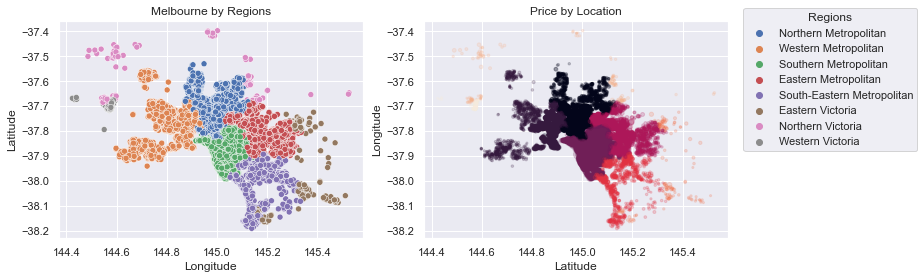

In [18]:
l = {i:j for i, j in zip(train.Regionname.unique(), range(9))}
_,ax=plt.subplots(1,2,figsize=(12,4))
sns.scatterplot(y='Latitude', x='Longitude',ax=ax[0],
                data=train, hue='Regionname')
ax[0].set_title('Melbourne by Regions')

ax[1].scatter(y='Latitude', x='Longitude',alpha=0.2,
              data=train, c=train.Regionname.map(l), 
              s=train.Price/1e5)
ax[1].set(xlabel='Latitude', ylabel='Longitude')
ax[1].set_title('Price by Location')
ax[0].legend(title='Regions', loc=(2.25,0.4));

Which region is the cheapest to buy a house?

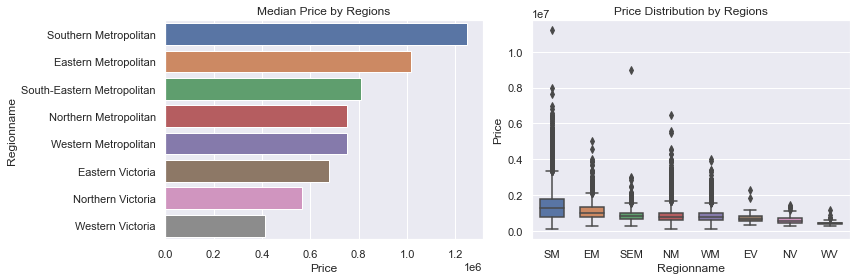

In [19]:
_, ax= plt.subplots(1,2, figsize=(12,4))
sns.barplot(y='Regionname', x='Price', data=train, orient='h',
            estimator=np.median, ci=None, ax=ax[0],
            order=train.groupby('Regionname').Price.median().sort_values(ascending=False).index)
ax[0].set(title='Median Price by Regions')

sns.boxplot(x='Regionname', y='Price', data=train, ax=ax[1], width=0.6,
            order=train.groupby('Regionname').Price.median().sort_values(ascending=False).index)
plt.xticks(range(8), ['SM', 'EM', 'SEM', 'NM', 'WM', 'EV', 'NV', 'WV'])
ax[1].set(title='Price Distribution by Regions')
plt.tight_layout();

We see that Southern Metropolitan is the most costly region, followed by Eastern Metropolitan. Western Victoria is the cheapest of them. Properties sold around Victoria are cheap.

So individuals willing to buy a cheap house could consider living in the Victoria regions.

<b>Price by Building Type</b>

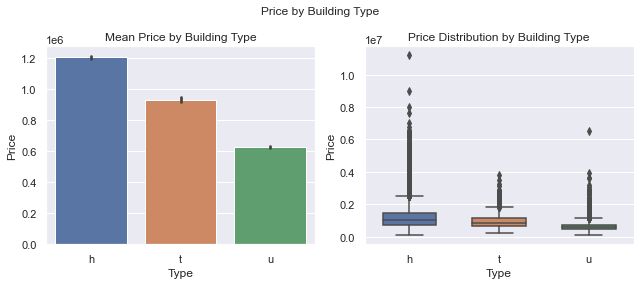

In [20]:
_, ax= plt.subplots(1,2, figsize=(9,4))
sns.barplot('Type', 'Price', data=train, estimator=np.mean, ax=ax[0])
ax[0].set_title('Mean Price by Building Type')
sns.boxplot('Type', 'Price', data=train, width=0.6, ax=ax[1])
ax[1].set_title('Price Distribution by Building Type')
plt.suptitle('Price by Building Type')
plt.tight_layout();

Building Type H costs the most on average, followed by T, and then U

<b>Yearly Revenue</b>

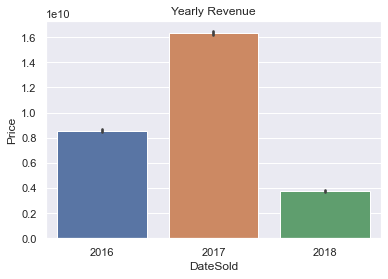

In [21]:
sns.barplot(train.DateSold.dt.year, train.Price, estimator=np.sum)
plt.title('Yearly Revenue');

<b>Average Monthly and Quarterly Revenue</b>

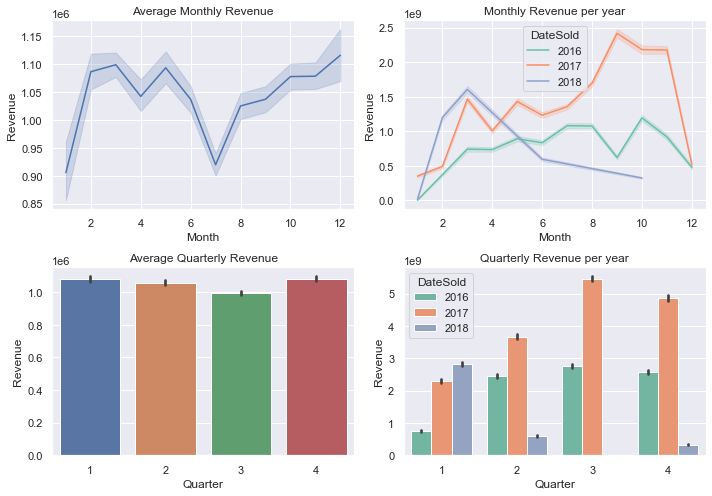

In [22]:
_, ax = plt.subplots(2,2, figsize=(10,7))
sns.lineplot(train.DateSold.dt.month, train.Price, estimator=np.mean,ax=ax[0,0])
ax[0,0].set(title='Average Monthly Revenue', xlabel='Month', ylabel='Revenue')
ax[0,0].set(title='Average Monthly Revenue', xlabel='Month', ylabel='Revenue')

sns.lineplot(train.DateSold.dt.month, train.Price, estimator=np.sum,ax=ax[0,1],
             hue=train.DateSold.dt.year, palette='Set2')
ax[0,1].set(title='Monthly Revenue per year', xlabel='Month', ylabel='Revenue')

sns.barplot(train.DateSold.dt.quarter, train.Price, estimator=np.mean, ax=ax[1,0])
ax[1,0].set(title='Average Quarterly Revenue', xlabel='Quarter', ylabel='Revenue')

sns.barplot(train.DateSold.dt.quarter, train.Price, estimator=np.sum, ax=ax[1,1],
            hue=train.DateSold.dt.year, palette='Set2')
ax[1,1].set(title='Quarterly Revenue per year', xlabel='Quarter', ylabel='Revenue')

plt.tight_layout();

1. On average, house prices increase from the beginning of the year to and falls around April. Rises in May and falls again from June to July before and then appreciates from August to the end of the year.
2. A look at the monthly revenue per year, we see that revenues fall around the end of the year.But the revenues increase from the beginning of the year, from January to March. The price data for 2018 stops at October.
3. There's no difference in house prices quarterly
4. More Revenue was recorded in the first quarter of 2018 than in any year.

<b>Year over year Revenues and month over month revenues</b>

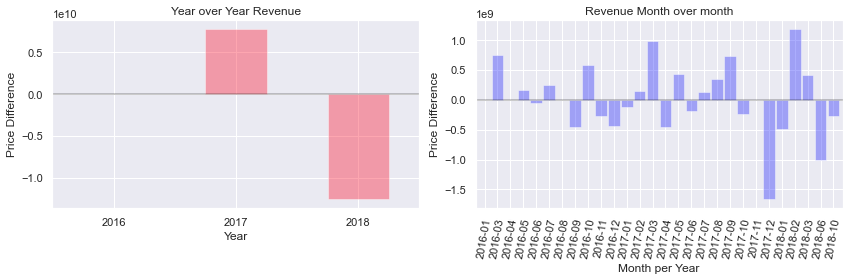

In [23]:
_, ax=plt.subplots(1,2,figsize=(12,4))
train.groupby(train.DateSold.dt.year).Price.sum().diff().plot.bar(
    rot=0, title='Year over Year Revenue', alpha=0.4,color='#fc213a',
    ylabel='Price Difference', ax=ax[0], xlabel='Year')
ax[0].axhline(0, ls='-', color='k', alpha=0.3)

train.groupby([train.DateSold.dt.strftime('%Y-%m')]).Price.sum().diff().plot.bar(
    title='Revenue Month over month', ax=ax[1], alpha=0.4,color='#2f33fa',
    width=0.9, rot=80,ylabel='Price Difference', xlabel='Month per Year')
ax[1].axhline(0, ls='-', color='k', alpha=0.3)
plt.tight_layout();

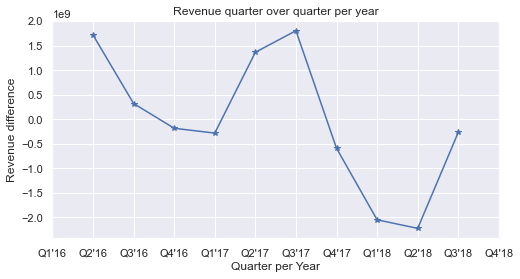

In [24]:
train.groupby([train.DateSold.dt.year, train.DateSold.dt.quarter]).Price.sum().diff().plot(
    figsize=(8,4), rot=0, title='Revenue quarter over quarter per year', marker='*',
    xlabel='Quarter per Year', ylabel='Revenue difference')
plt.xticks(range(12), ['Q1\'16', 'Q2\'16', 'Q3\'16', 'Q4\'16',
                       'Q1\'17', 'Q2\'17', 'Q3\'17', 'Q4\'17',
                       'Q1\'18', 'Q2\'18', 'Q3\'18', 'Q4\'18']);

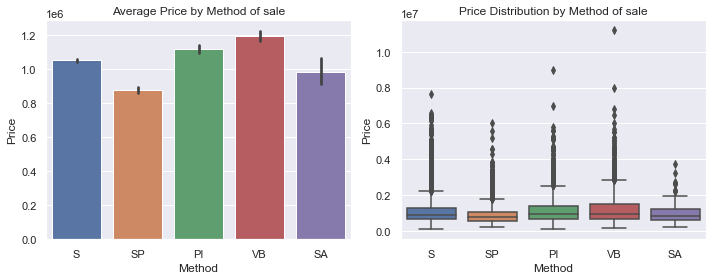

In [25]:
_, ax = plt.subplots(1,2,figsize=(10,4))
sns.barplot('Method', 'Price', data=train, ax=ax[0])
ax[0].set(title='Average Price by Method of sale')

sns.boxplot('Method', 'Price', data=train, ax=ax[1])
ax[1].set(title='Price Distribution by Method of sale')
plt.tight_layout();

S - property sold; SP - property sold prior; PI - property passed in; VB - vendor bid; SA - sold after auction

Properties sold by vendor bid were sold more than the other methods, on average. Followed by Property passed in, with properties sold prior were sold the least.

<b>Suburbs</b>

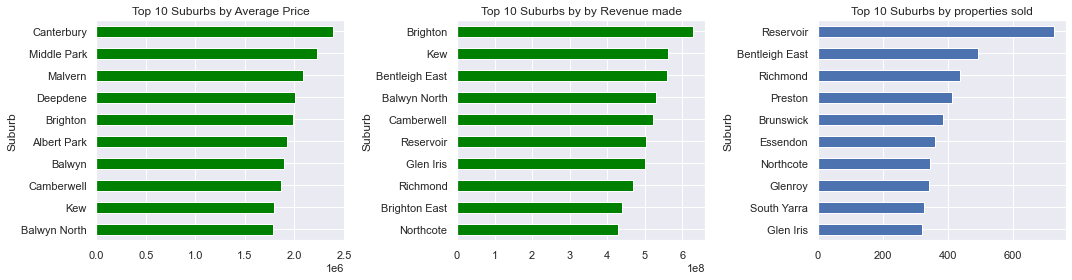

In [26]:
_, ax = plt.subplots(1,3,figsize=(15,4))
train.groupby('Suburb').Price.mean().sort_values()[-10:].plot.barh(
    title='Top 10 Suburbs by Average Price', ax=ax[0], color='green')

train.groupby('Suburb').Price.sum().sort_values()[-10:].plot.barh(
    title='Top 10 Suburbs by by Revenue made', ax=ax[1], color='green')

train.groupby('Suburb').Suburb.count().sort_values()[-10:].plot.barh(
    title='Top 10 Suburbs by properties sold', ax=ax[2])

plt.tight_layout();

<li>Properties sold in Canterbury costs the most on average. Followed by Middle Park and Malvern</li>
<li> Brighton has made the most revenues from  2016 - 2018, followed by Kew and Bentleigh East</li>
<li>Most properties have been sold in Reservoir, followed by Bentleigh East and Richmond.</li>

<b>Which real estate agent has sold the most?</b>

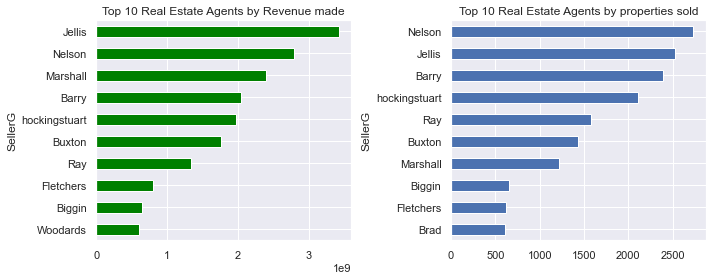

In [27]:
_, ax = plt.subplots(1,2,figsize=(10,4))
train.groupby('SellerG').Price.sum().sort_values()[-10:].plot.barh(
    title='Top 10 Real Estate Agents by Revenue made', ax=ax[0], color='green')

train.groupby('SellerG').Price.count().sort_values()[-10:].plot.barh(
    title='Top 10 Real Estate Agents by properties sold', ax=ax[1])

plt.tight_layout();

<li>Jellis has made over $3billion in all properties sold, folllowed by Nelson over $2 billion, with Woodards real estate making the least revenues</li>
<li>While Jellis has made the highest revenue, Nelson has sold the highest number of properties (a little over than Jellis)</li>

<b>Council Area</b>

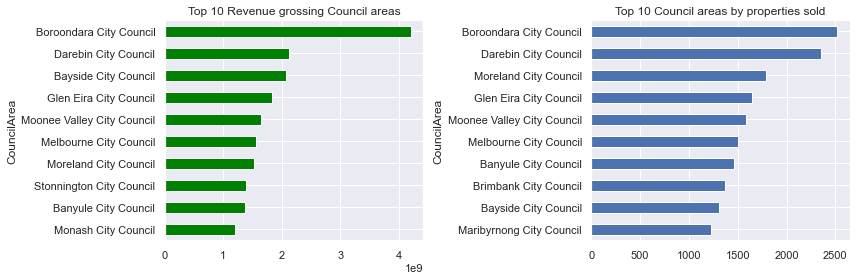

In [28]:
_, ax = plt.subplots(1,2,figsize=(12,4))
train.groupby('CouncilArea').Price.sum().sort_values()[-10:].plot.barh(
    title='Top 10 Revenue grossing Council areas', ax=ax[0], color='green')

train.groupby('CouncilArea').Price.count().sort_values()[-10:].plot.barh(
    title='Top 10 Council areas by properties sold', ax=ax[1])

plt.tight_layout();

<li>Boroondara city council has grossed the highest revenue from properties sold. It also has the number of properties sold.

<b>Number of Car spots</b>

In [29]:
train.Car.value_counts()

2.0     9367
1.0     7400
0.0     1251
3.0     1234
4.0      907
5.0      113
6.0      105
7.0       19
8.0       18
10.0       5
9.0        2
18.0       1
11.0       1
Name: Car, dtype: int64

We will cap car spots more than 7 to 7, since many properties sold contain very few of them

In [30]:
train.loc[train.Car > 6, 'Car'] = 7
test.loc[test.Car > 6, 'Car'] = 7

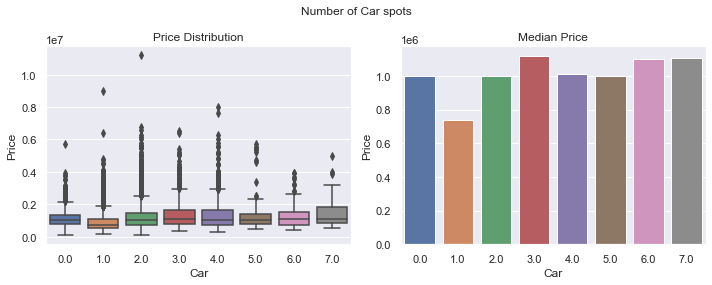

In [31]:
_, ax = plt.subplots(1,2,figsize=(10,4))
sns.boxplot('Car', 'Price', data=train, ax=ax[0])
ax[0].set(title='Price Distribution')
sns.barplot('Car', 'Price', data=train, ax=ax[1], 
            estimator=np.median, ci=None)
ax[1].set(title='Median Price')
plt.suptitle('Number of Car spots')
plt.tight_layout();

<b>Year Built</b>

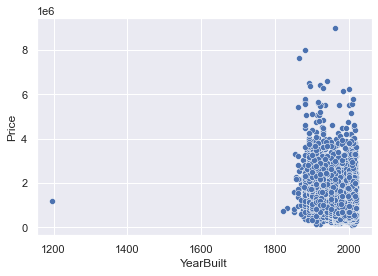

In [32]:
sns.scatterplot('YearBuilt', 'Price', data=train);

There's an outlier in the Year the property was built. There is a likelihood that it was recorded as error. We may choose to remove it or replace with the median value of year built.

Binning the Yearbuilt by decade built

In [33]:
train.YearBuilt = train.YearBuilt//10*10
test.YearBuilt = test.YearBuilt//10*10

In [34]:
# replacing yearbuilt outlier with median year
train.loc[train.YearBuilt < 1800, 'YearBuilt'] = train.YearBuilt.median()
test.loc[test.YearBuilt < 1800, 'YearBuilt'] = train.YearBuilt.median()

<b>Price by Buildng Area and Landsize</b>

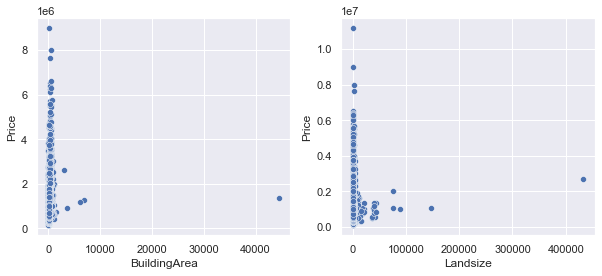

In [35]:
_, ax = plt.subplots(1,2,figsize=(10,4))
sns.scatterplot('BuildingArea', 'Price', data=train, ax=ax[0])
sns.scatterplot('Landsize', 'Price', data=train, ax=ax[1]);

Building Area has an outlier. Building areas > 10000. Landsize > 200000 are outliers.

<b>Price by Number of Bathrooms, rooms, bedrooms</b>

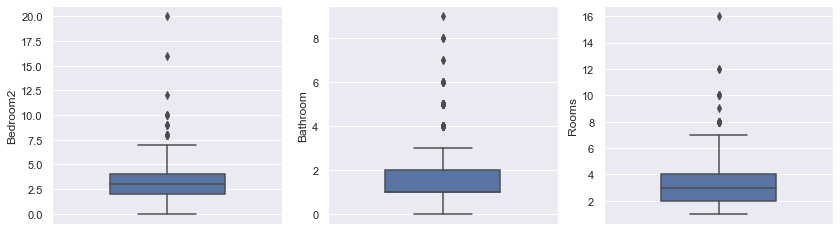

In [36]:
_, ax = plt.subplots(1,3,figsize=(14,4))
sns.boxplot(y='Bedroom2', data=train, ax=ax[0], width=0.5)
sns.boxplot(y='Bathroom', data=train, ax=ax[1], width=0.5)
sns.boxplot(y='Rooms', data=train, ax=ax[2], width=0.5);

There are outliers in the number of bedrooms, the number of rooms, the number of bathrooms

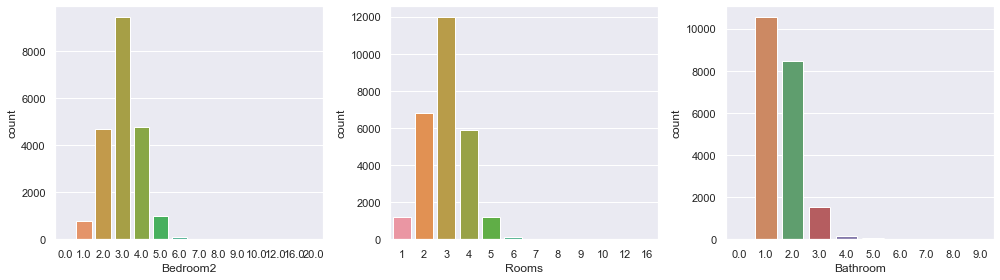

In [37]:
_, ax = plt.subplots(1,3,figsize=(14,4))
sns.countplot('Bedroom2', data=train, ax=ax[0])
sns.countplot('Rooms', data=train, ax=ax[1])
sns.countplot('Bathroom', data=train, ax=ax[2])
plt.tight_layout();

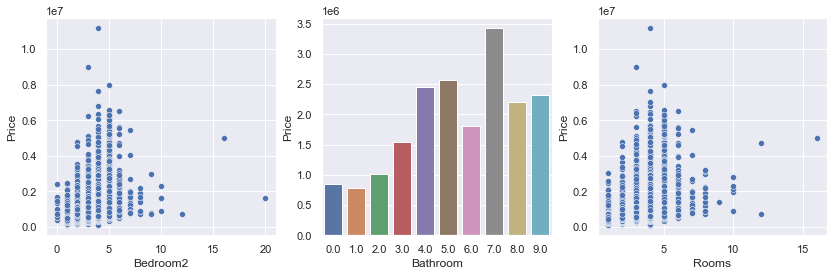

In [38]:
_, ax = plt.subplots(1,3,figsize=(14,4))
sns.scatterplot('Bedroom2', 'Price', data=train, ax=ax[0])
sns.barplot('Bathroom', 'Price', data=train, ax=ax[1], 
            ci=None, estimator=np.median)
sns.scatterplot('Rooms', 'Price', data=train, ax=ax[2]);

1. There's a correlation between Price of a property and the number of bedrooms
2. The price of a house increases with number of bathrooms
3. The price of a property also increases with number of rooms

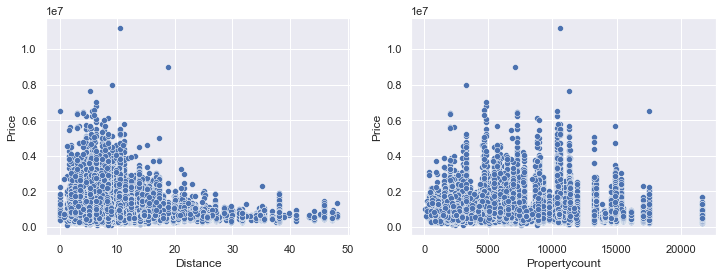

In [39]:
_, ax = plt.subplots(1,2,figsize=(12,4))
sns.scatterplot('Distance', 'Price', data=train, ax=ax[0])
sns.scatterplot('Propertycount', 'Price', data=train, ax=ax[1]);

The price of a house decreases weakly with decrease in distance of property from CBD

<b>Feature Engineering</b>

In [40]:
train[['YearSold', 'WeekSold', 'WkDaySold']] = train.DateSold.dt.isocalendar()
test[['YearSold', 'WeekSold', 'WkDaySold']] = test.DateSold.dt.isocalendar()

train['MonthSold'] = train.DateSold.dt.month
test['MonthSold'] = test.DateSold.dt.month

train['QuarterSold'] = train.DateSold.dt.quarter
test['QuarterSold'] = test.DateSold.dt.quarter

In [41]:
def RegionType(x):
    x = str(x)
    if 'Metropolitan' in x:
        x = 'Metropolitan'
    elif 'Victoria' in x:
        x =  'Victoria'
    else:
        x = np.nan
    return x

In [42]:
train['State'] = train.Regionname.apply(RegionType)
test['State'] = test.Regionname.apply(RegionType)

#### Categorical Encoding categorical variables with high cardinality

In [43]:
suburbs = train.append(test).Suburb.value_counts().to_dict()

In [44]:
train.Suburb = train.Suburb.map(suburbs)
test.Suburb = test.Suburb.map(suburbs)

In [45]:
areacouncil = train.append(test).CouncilArea.value_counts().to_dict()

In [46]:
train.CouncilArea = train.CouncilArea.map(areacouncil)
test.CouncilArea = test.CouncilArea.map(areacouncil)

In [47]:
test.Method.unique(), train.Method.unique()

(array(['SS', 'VB', 'SN', 'S', 'PI', 'W', 'SP', 'PN', 'SA'], dtype=object),
 array(['S', 'SP', 'PI', 'VB', 'SA'], dtype=object))

There are method sales not in train but in test, we will drop the rows

In [48]:
method_stay = list(set(test.Method).intersection(set(train.Method)))

In [49]:
test = test.loc[test.Method.isin(method_stay)]

<b>Filling Missing Values</b>

1. For categorical variables, we will fill in with their mode (most frequent class)
2. For numerical variables, because most of the them are highly skewed, we will fill in using their median values

In [50]:
# Region Name
train.loc[train.Regionname.isna(), 'Regionname'] = train.Regionname.mode()[0]
test.loc[test.Regionname.isna(), 'Regionname'] = train.Regionname.mode()[0]

# State
train.loc[train.State.isna(), 'State'] = train.loc[train.State.isna(), 'Regionname'].map(RegionType)
test.loc[test.State.isna(), 'State'] = test.loc[test.State.isna(), 'Regionname'].map(RegionType)

In [51]:
# Number of car spot

train.loc[train.Car.isna(), 'Car'] = train.Car.mode()[0]
test.loc[test.Car.isna(), 'Car'] = train.Car.mode()[0]

In [52]:
# Council area
train.loc[train.CouncilArea.isna(), 'CouncilArea'] = train.CouncilArea.mode()[0]
test.loc[test.CouncilArea.isna(), 'CouncilArea'] = train.CouncilArea.mode()[0]

We will fill in the building area using the location and the type of property and region

In [53]:
# building Area
building_area = train.append(test).groupby([train.append(test).Longitude.round(1),
                                            train.append(test).Latitude.round(1), 
                                            'Type', 'Regionname']).BuildingArea.mean()
building_area.index.names = ['Longitude1', 'Latitude1', 'Type', 'Regionname']

In [54]:
train['Longitude1'] = train.Longitude.round(1)
test['Longitude1'] = test.Longitude.round(1)

train['Latitude1'] = train.Latitude.round(1)
test['Latitude1'] = test.Latitude.round(1)

In [55]:
build_miss_tr = train[train.BuildingArea.isna()].drop('BuildingArea',1).merge(
    building_area, on=building_area.index.names, how='left')

build_miss_te = test[test.BuildingArea.isna()].drop('BuildingArea',1).merge(
    building_area, on=building_area.index.names, how='left')

In [56]:
# replacing
train.loc[train.BuildingArea.isna(), 'BuildingArea'] = build_miss_tr.BuildingArea.values
test.loc[test.BuildingArea.isna(), 'BuildingArea'] = build_miss_te.BuildingArea.values

In [57]:
train.loc[train.BuildingArea.isna(), 'BuildingArea'] = train.BuildingArea.median()
test.loc[test.BuildingArea.isna(), 'BuildingArea'] = train.BuildingArea.median()

For Landing Area

In [58]:
landsize = train.append(test).groupby([train.append(test).Longitude.round(1),
                                       train.append(test).Latitude.round(1), 
                                       'Type', 'Regionname']).Landsize.mean()

landsize.index.names = ['Longitude1', 'Latitude1', 'Type', 'Regionname']

In [59]:
land_miss_tr = train[train.Landsize.isna()].drop('Landsize',1).merge(
    landsize, on=landsize.index.names, how='left')

land_miss_te = test[test.Landsize.isna()].drop('Landsize',1).merge(
    landsize, on=landsize.index.names, how='left')

In [60]:
# replacing
train.loc[train.Landsize.isna(), 'Landsize'] = land_miss_tr.Landsize.values
test.loc[test.Landsize.isna(), 'Landsize'] = land_miss_te.Landsize.values

In [61]:
train.loc[train.Landsize.isna(), 'Landsize'] = train.Landsize.median()
test.loc[test.Landsize.isna(), 'Landsize'] = train.Landsize.median()

In [62]:
# Distance
train.Distance.fillna(train.Distance.median(), inplace=True)
test.Distance.fillna(train.Distance.median(), inplace=True)

Number of bedrooms and bathrooms 

In [63]:
bedroom = train.append(test).groupby('Type').Bedroom2.apply(lambda x: x.mode()[0])
bathroom = train.append(test).groupby('Type').Bathroom.apply(lambda x: x.mode()[0])

In [64]:
# replacing
train.loc[train.Bedroom2.isna(), 'Bedroom2'] = train[train.Bedroom2.isna()].Type.map(bedroom.to_dict())
test.loc[test.Bedroom2.isna(), 'Bedroom2'] = test[test.Bedroom2.isna()].Type.map(bedroom.to_dict())

In [65]:
train.loc[train.Bathroom.isna(), 'Bathroom'] = train[train.Bathroom.isna()].Type.map(bathroom.to_dict())
test.loc[test.Bathroom.isna(), 'Bathroom'] = test[test.Bathroom.isna()].Type.map(bathroom.to_dict())

In [66]:
train.Propertycount = train.Propertycount.fillna(train.Propertycount.median())
test.Propertycount = test.Propertycount.fillna(train.Propertycount.median())

Filling in the YearBuilt of property based on the most frequent property sold at that location and type of property sold and year sold

In [67]:
yearbuilt = train.append(test).groupby([train.append(test).Longitude.round(1),
                                        train.append(test).Latitude.round(1),
                                        'Type', 'YearSold']).YearBuilt.apply(lambda x: x.mode().min())
yearbuilt.index.names = ['Longitude1', 'Latitude1', 'Type', 'YearSold']

In [68]:
yearmiss_tr = train[train.YearBuilt.isna()].drop('YearBuilt', 1).merge(
    yearbuilt, on=yearbuilt.index.names, how='left')

yearmiss_te = test[test.YearBuilt.isna()].drop('YearBuilt', 1).merge(
    yearbuilt, on=yearbuilt.index.names, how='left')

In [69]:
# replacing
train.loc[train.YearBuilt.isna(), 'YearBuilt'] = yearmiss_tr.YearBuilt.values
test.loc[test.YearBuilt.isna(), 'YearBuilt'] = yearmiss_te.YearBuilt.values

In [70]:
# filling in missing rows with median year built
train.loc[train.YearBuilt.isna(), 'YearBuilt']  = train.YearBuilt.median()
test.loc[test.YearBuilt.isna(), 'YearBuilt'] = train.YearBuilt.median()

In [71]:
train.Type = train.Type.map({'u':0, 't':1, 'h':2})
test.Type = test.Type.map({'u':0, 't':1, 'h':2})

In [72]:
method = {i:j for i,j in zip(train.Method.unique(), range(len(train.Method.unique())))}

In [73]:
region = {i:j for i,j in zip(train.Regionname.unique(), 
                             range(len(train.Regionname.unique())))}

state = {i:j for i,j in zip(train.State.unique(), range(len(train.State.unique())))}

In [74]:
train.Method = train.Method.map(method)
test.Method = test.Method.map(method)

In [75]:
train.Regionname = train.Regionname.map(region)
test.Regionname = test.Regionname.map(region)

train.State = train.State.map(state)
test.State = test.State.map(state)

In [76]:
drop_cols = ['Longitude1', 'Latitude1', 'Longitude', 'Latitude', 
             'Address', 'DateSold', 'SellerG', 'Postcode']

Dropping columns

In [77]:
train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

<b>Outlier Treatment</b>

<b><i>Data Transformation</i></b>

In [78]:
num_cols = data.select_dtypes('number').columns.drop(['Latitude', 'Longitude', 'Postcode'])

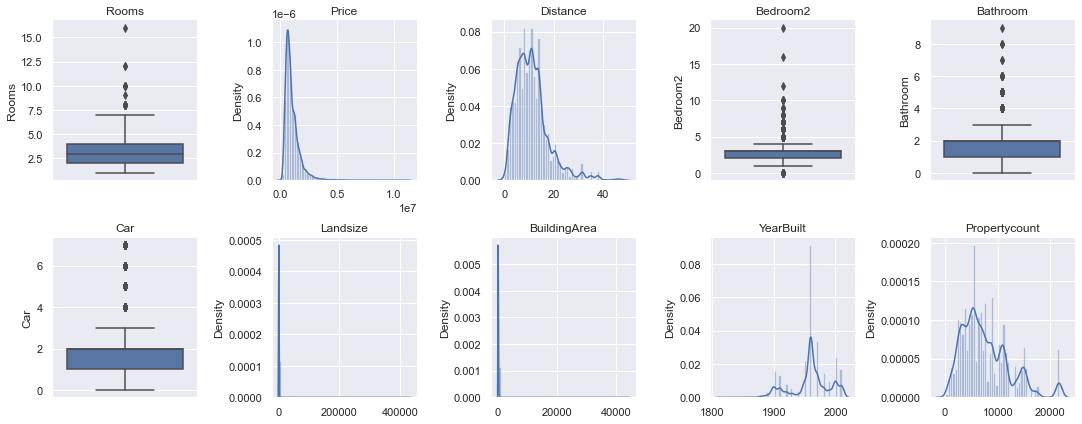

In [79]:
plt.figure(figsize=(15,6))
for i, col in enumerate(num_cols):
    plt.subplot(2,5,i+1)
    if col not in ['Rooms', 'Bedroom2', 'Bathroom', 'Car']:
        sns.distplot(train[col])
    else:
        sns.boxplot(y=train[col])
    plt.title(col)
    plt.xlabel('')
sns.despine()
plt.tight_layout();

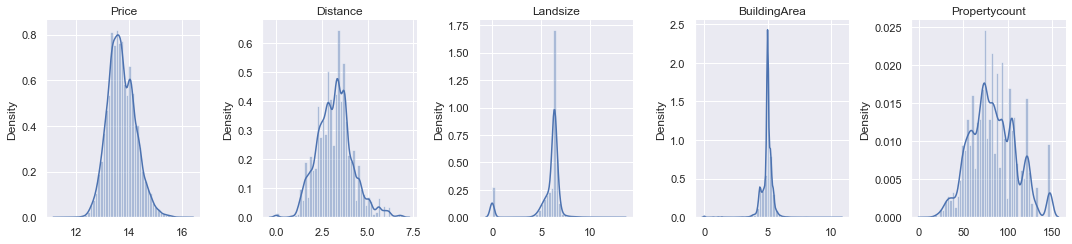

In [80]:
plt.figure(figsize=(15,3.5))
i = 0
for col in num_cols:
    if col not in ['Price', 'BuildingArea','Landsize',
                   'Distance', 'Propertycount']:
        continue
    plt.subplot(1,5,i+1)
    if col in ['Price', 'BuildingArea','Landsize']:
        sns.distplot(np.log(1+train[col]))
        i += 1
    if col in ['Distance', 'Propertycount']:
        sns.distplot(np.sqrt(train[col]))
        i += 1
    plt.title(col)
    plt.xlabel('')
sns.despine()
plt.tight_layout();

In [81]:
# transformation
train[['Distance', 'Propertycount']] = np.sqrt(train[['Distance', 'Propertycount']])
test[['Distance', 'Propertycount']] = np.sqrt(test[['Distance', 'Propertycount']])

train[['Price', 'BuildingArea','Landsize']] = np.log1p(train[['Price', 'BuildingArea','Landsize']])
test[['BuildingArea','Landsize']] = np.log1p(test[['BuildingArea','Landsize']])

In [82]:
def outlierReplacement(df, columns):
    df_copy = df.copy(deep=True)
    for col in columns:
        zscore_ = stats.zscore(df_copy[col])
        outliers = (zscore_ < -3) | (zscore_ > 3) # get outliers
        inliers = ~((zscore_ < -3) | (zscore_ > 3)) # get inliers
        
        # get mean of inliers
        mean_ = np.mean(df_copy[col][inliers])
        
        # replacing
        df_copy.loc[outliers, col] = mean_
        print(f'{col}: {outliers.sum()} rows replaced')
    return df_copy

In [83]:
# capping Number of rooms, bedrooms and Bathrooms
train.loc[train.Rooms > 7, 'Rooms'] = 7
test.loc[test.Rooms > 7, 'Rooms'] = 7

train.loc[train.Bedroom2 > 7, 'Bedroom2'] = 7
test.loc[test.Bedroom2 > 7, 'Bedroom2'] = 7

train.loc[train.Bathroom > 5, 'Bathroom'] = 5
test.loc[test.Bathroom > 5, 'Bathroom'] = 5

Replacing Outliers with mean values

In [84]:
train = outlierReplacement(train, ['Price','BuildingArea','Landsize','Distance', 'Propertycount'])

Price: 122 rows replaced
BuildingArea: 263 rows replaced
Landsize: 1949 rows replaced
Distance: 282 rows replaced
Propertycount: 0 rows replaced


In [85]:
test = outlierReplacement(test, ['BuildingArea','Landsize','Distance', 'Propertycount'])

BuildingArea: 53 rows replaced
Landsize: 378 rows replaced
Distance: 63 rows replaced
Propertycount: 0 rows replaced


<b>Correlation Matrix</b>

In [86]:
corr = train.corr()

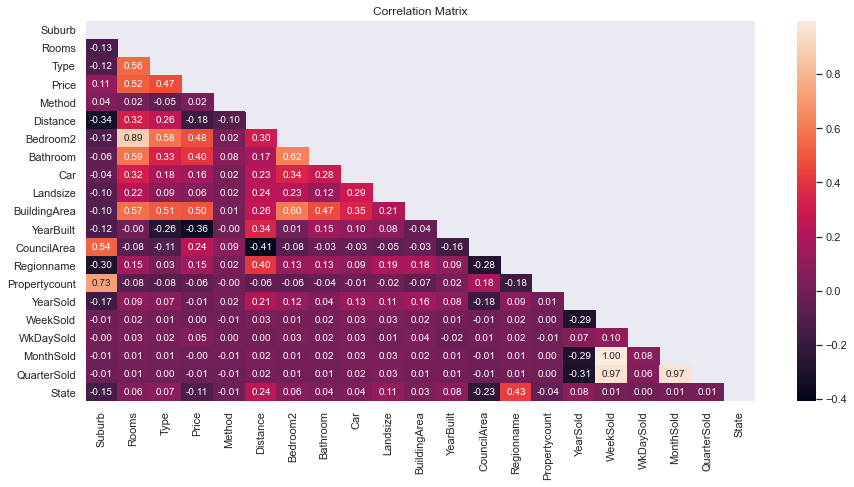

In [87]:
plt.figure(figsize=(15,7))
sns.heatmap(corr, mask=np.triu(corr), annot=True, fmt='.2f')
plt.title('Correlation Matrix');

1. The number of bedrooms and the number of rooms strongly correlate
2. The Month, Quarter, and Week, the property was sold also strongly correlate.

We will drop the number of bedrooms, the quarter and week property was sold, since they all encode similar information.

In [88]:
drop_cols = ['Bedroom2', 'QuarterSold', 'WeekSold']

In [89]:
train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

In [90]:
train.dtypes.value_counts()

float64    9
int64      7
UInt32     2
dtype: int64

In [91]:
test.dtypes.value_counts()

float64    8
int64      7
UInt32     2
dtype: int64

In [92]:
train[['YearSold', 'WkDaySold']] = train.select_dtypes('UInt32').astype('int')
test[['YearSold', 'WkDaySold']] = test.select_dtypes('UInt32').astype('int')

In [93]:
# reseting index
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

We will rename the train and test sets into trainset and newtest. From the trainset we will split the data into train and test sets

In [94]:
trainset = train
newtest = test

In [95]:
# to release memory
del train, test, data

<b>Helper Functions</b>

In [96]:
def splitData(trainset):
    train, test = train_test_split(trainset, test_size=0.2, random_state=3821)
    return train, test

In [97]:
def rmsle(y, ypred):
    rmsle_ = mean_squared_error(y, ypred, squared=False)
    return rmsle_

In [98]:
def metrics(reg, x, y):
    ypred = reg.predict(x)
    rmsle_ = mean_squared_error(y, ypred, squared=False)
    return rmsle_

In [99]:
def buildModel(reg):
    reg.fit(xtrain, ytrain)
    return reg

In [100]:
# rmsle scorers
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [101]:
def residualPlots(reg, x, y):
    ypred = np.expm1(reg.predict(x))
    y = np.expm1(y)
    residuals =  y - ypred
    plt.scatter(ypred, residuals, alpha=0.4)
    plt.axhline(0, ls= '--', alpha=0.6, color='k')
    corr = stats.pearsonr(residuals, ypred)[0]
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title(reg.__class__.__name__+ '\nCorr: {}'.format(corr.round(2)))

In [102]:
def crossvalidate(reg, cv, scorer):
    cvs = -cross_val_score(reg, xtrain, ytrain, cv=cv, scoring=scorer)
    print(cvs.mean().round(5), '+/-', cvs.std().round(3))

In [103]:
def featureImportance(reg):
    import_ = pd.Series(reg.feature_importances_, 
                        index=xtrain.columns).sort_values()
    import_.plot.barh(title=reg.__class__.__name__)
    plt.xlabel('Importance scores')
    plt.ylabel('Features')

<b>Splitting Dataset</b>

In [104]:
train, test = splitData(trainset)

In [105]:
train.shape, test.shape

((21797, 18), (5450, 18))

In [106]:
xtrain, ytrain = train.drop(columns='Price'), train.Price
xtest, ytest = test.drop(columns='Price'), test.Price

<b>Instantiating models</b>

In [107]:
seed = 3242 # seeding for reproducibility

In [108]:
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

In [109]:
rf_params = {
    'max_depth': 20,
    'max_features': 0.3,
    'min_samples_leaf': 1, 
    'min_samples_split': 10, 
    'n_estimators': 100,
}

In [110]:
gbm_params = {
    'learning_rate': 0.035012180837755306, 
    'max_depth': 7,
    'max_features' : 0.6423210467025975,
    'min_samples_leaf': 6,
    'min_samples_split': 6,
    'n_estimators': 950,
    'subsample': 0.6520124776094509
}

In [111]:
lgb_params = {
    'colsample_bytree' : 0.3017552453685504,
    'learning_rate': 0.066994322547831,
    'max_depth': 7,
    'min_child_samples': 31,
    'min_child_weight' : 0.1,
    'n_estimators' : 600,
    'num_leaves' : 40,
    'reg_alpha' : 2.2312704179986822e-05,
    'reg_lambda': 0.19321232759108778,
    'subsample': 0.8571514289081977,
    'subsample_freq' : 2,
    'importance_type' : 'gain'
}

In [112]:
rf = RandomForestRegressor(random_state=seed, **rf_params)
gbm = GradientBoostingRegressor(random_state=seed, **gbm_params)
lgbm = lgb.LGBMRegressor(random_state=seed, **lgb_params)

<b>Training</b>

In [113]:
buildModel(rf);

In [114]:
buildModel(gbm);

In [115]:
buildModel(lgbm);

<b>Performance Diagnostics</b>

In [116]:
print('Train RMSLE: {:.6f}'.format(-rmsle_scorer(rf, xtrain, ytrain)))
print('Test RMSLE: {:.6f}'.format(-rmsle_scorer(rf, xtest, ytest)))

Train RMSLE: 0.143872
Test RMSLE: 0.203914


In [117]:
print('Train RMSLE: {:.6f}'.format(-rmsle_scorer(gbm, xtrain, ytrain)))
print('Test RMSLE: {:.6f}'.format(-rmsle_scorer(gbm, xtest, ytest)))

Train RMSLE: 0.135814
Test RMSLE: 0.195571


In [118]:
print('Train RMSLE: {:.6f}'.format(-rmsle_scorer(lgbm, xtrain, ytrain)))
print('Test RMSLE: {:.6f}'.format(-rmsle_scorer(lgbm, xtest, ytest)))

Train RMSLE: 0.168991
Test RMSLE: 0.194735


<b>Validation</b>

In [119]:
%%time
crossvalidate(rf, kfold, rmsle_scorer)

0.21097 +/- 0.004


In [120]:
%%time
crossvalidate(gbm, kfold, rmsle_scorer)

0.20191 +/- 0.004


In [121]:
%%time
crossvalidate(lgbm, kfold, rmsle_scorer)

0.2014 +/- 0.005


<b>Plotting</b>

<b>Feature Importance</b>

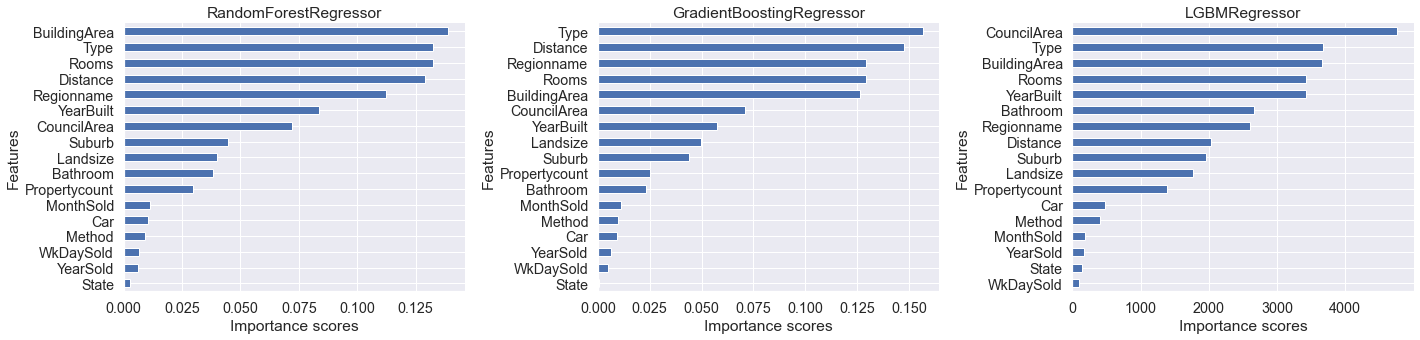

In [122]:
sns.set(font_scale=1.3)

plt.figure(figsize=(20,5))
plt.subplot(131)
featureImportance(rf)

plt.subplot(132)
featureImportance(gbm)

plt.subplot(133)
featureImportance(lgbm)
sns.despine()
plt.tight_layout();

The features that are helpful in predicting the selling price of a property can be grouped into two: one partaining to the characteristics of the property on sale and the other, to the region or location, where it is located.
This makes sense because for a property to be sold, the size of the property, the number of rooms, the location it is etc, all have an effect in determining the sale of a property. 

We see that the least important features are: the state the property is located, the year of sale of property, the Day it was sold, the the method of sale.
For all models, the top 10 important features are the building area, the type of property, the number of rooms, the distance ti CBM, the year property was built, the region, the council area and surburb the property is located, the number of properties that exist in the surburb at that time and finally, the landsize.

<b>Residual Plots

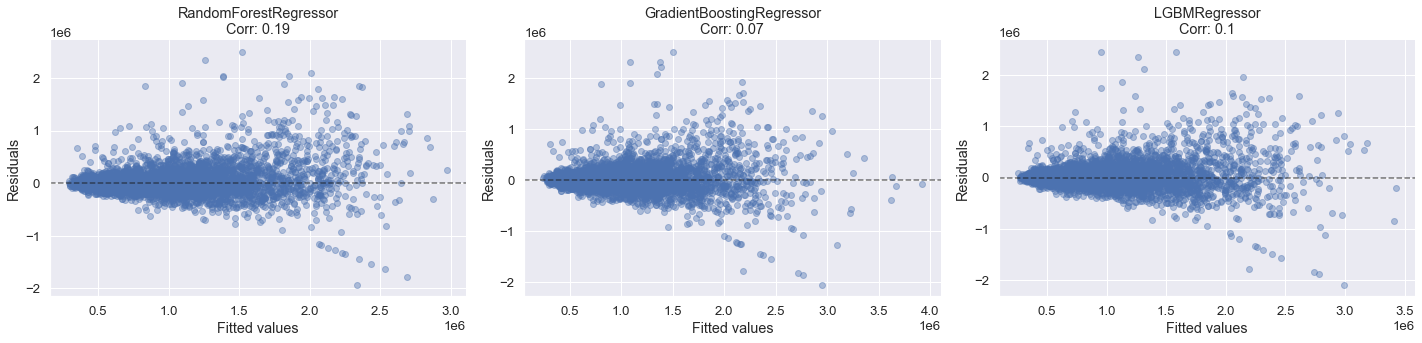

In [123]:
sns.set(font_scale=1.2)

plt.figure(figsize=(20,5))
plt.subplot(131)
residualPlots(rf, xtest, ytest)

plt.subplot(132)
residualPlots(gbm, xtest, ytest)

plt.subplot(133)
residualPlots(lgbm, xtest, ytest)
sns.despine()
plt.tight_layout();

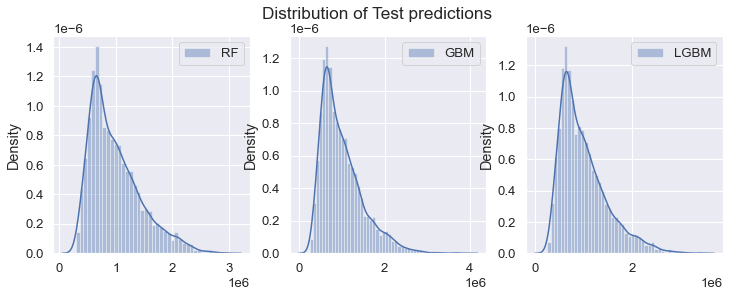

In [124]:
_, ax = plt.subplots(1,3,figsize=(12,4))
sns.distplot(np.expm1(rf.predict(xtest)), ax=ax[0], label='RF')
sns.distplot(np.expm1(gbm.predict(xtest)), ax=ax[1], label='GBM')
sns.distplot(np.expm1(lgbm.predict(xtest)), ax=ax[2], label='LGBM')
for i in range(3):
    ax[i].legend()
plt.suptitle('Distribution of Test predictions');

<b>New Samples Prediction</b>

In [125]:
rf_pred = np.expm1(rf.predict(newtest))

In [126]:
gbm_pred = np.expm1(gbm.predict(newtest))

In [127]:
lgb_pred = np.expm1(lgbm.predict(newtest))

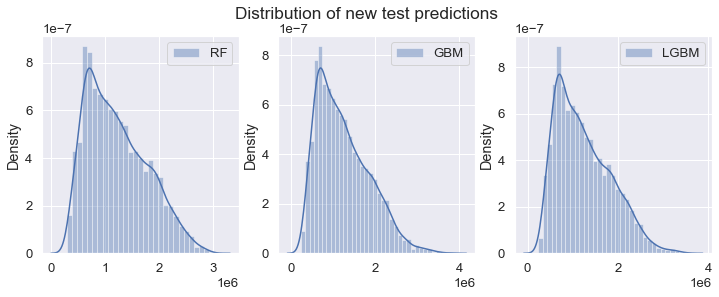

In [128]:
_, ax = plt.subplots(1,3,figsize=(12,4))
sns.distplot(rf_pred, ax=ax[0], label='RF')
sns.distplot(gbm_pred, ax=ax[1], label='GBM')
sns.distplot(lgb_pred, ax=ax[2], label='LGBM')
for i in range(3):
    ax[i].legend()
plt.suptitle('Distribution of new test predictions');

In [129]:
pd.DataFrame({'Rf': rf_pred, 'GBM' : gbm_pred, 'LGBM' : lgb_pred})

,Rf,GBM,LGBM
0,9.042362e+05,8.690885e+05,8.733447e+05
1,1.172692e+06,1.124284e+06,1.119686e+06
2,1.269191e+06,1.260052e+06,1.180214e+06
3,7.096640e+05,6.422034e+05,6.166821e+05
4,1.054825e+06,1.142638e+06,1.150077e+06
...,...,...,...
5771,1.050529e+06,1.108068e+06,1.115942e+06
5772,5.338421e+05,5.052818e+05,4.943738e+05
5773,1.023971e+06,1.023950e+06,9.661389e+05
5774,1.041452e+06,1.065165e+06,1.056636e+06


In [130]:
pd.DataFrame({'Rf': rf_pred, 'GBM' : gbm_pred, 'LGBM' : lgb_pred}).corr()

,Rf,GBM,LGBM
Rf,1.000000,0.977272,0.978049
GBM,0.977272,1.000000,0.986821
LGBM,0.978049,0.986821,1.000000


In [131]:
gc.collect()

18305